# Model Building - `v2`

In [1]:
from warnings import filterwarnings
from time import perf_counter

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer

from helpers import constants as C

In [2]:
filterwarnings("ignore")

In [3]:
df = pd.read_csv("data/processed/Gurgaon/res_apartment.csv")
print(df.shape)
df.head()

(4049, 20)


,PROP_ID,CITY,PRICE,AREA,PROP_HEADING,DESCRIPTION,PROPERTY_TYPE,FURNISH,FACING,AGE,BEDROOM_NUM,PROP_NAME,BALCONY_NUM,FLOOR_NUM,LATITUDE,LONGITUDE,LOCALITY_NAME,SOCIETY_NAME,ADDRESS,LUXURY_CATEGORY
0,d68894450,gurgaon,1100000.0,10777.0,5 bhk flat in sector 42 gurgaon,a 4 bhk duplex flat for rent in sector 42 gurg...,residential apartment,Furnished,North-East,5-10 Year Old Property,5.0,dlf the magnolias,4.0,low rise,28.454897,77.105367,sector 42 gurgaon,dlf the magnolias,a 209,2.0
1,y70794212,gurgaon,1775000.0,600.0,1 bhk flat in sector 95 gurgaon,"ramsons kshitij , sector 95 imt manesar, main ...",residential apartment,Semifurnished,East,1-5 Year Old Property,1.0,ramsons kshitij,1.0,low rise,28.416679,76.902677,sector 95 gurgaon,ramsons kshitij,216,0.0
2,s70190322,gurgaon,2000000.0,366.0,1 bhk flat in sector 95 gurgaon,"situated in sector 95 gurgaon, rof ananda is a...",residential apartment,Unfurnished,North-East,1-5 Year Old Property,1.0,rof ananda,1.0,low rise,28.484814,77.080853,sector 95 gurgaon,rof ananda,405,0.0
3,c64640776,gurgaon,2033000.0,555.0,2 bhk flat in sector 86 gurgaon,check out this 2 bhk apartment for sale in gls...,residential apartment,Semifurnished,East,Under Construction,2.0,gls avenue 86,2.0,mid rise,28.401966,76.942206,sector 86 gurgaon,gls avenue 86,301,2.0
4,f70190474,gurgaon,2050000.0,366.0,1 bhk flat in sector 95 gurgaon,located in the popular residential address of ...,residential apartment,Semifurnished,North-East,1-5 Year Old Property,1.0,rof ananda,1.0,mid rise,28.484814,77.080853,sector 95 gurgaon,rof ananda,509,0.0


In [4]:
df.isnull().sum()

PROP_ID               0
CITY                  0
PRICE                 0
AREA                  0
PROP_HEADING          0
DESCRIPTION           0
PROPERTY_TYPE         0
FURNISH               0
FACING                0
AGE                   0
BEDROOM_NUM           0
PROP_NAME             0
BALCONY_NUM           0
FLOOR_NUM             0
LATITUDE              0
LONGITUDE             0
LOCALITY_NAME         0
SOCIETY_NAME          0
ADDRESS            2122
LUXURY_CATEGORY       0
dtype: int64

In [5]:
target = "PRICE"
num_cols = [
    "AREA",
]
cat_cols = [
    "FURNISH",
    "AGE",
    "BEDROOM_NUM",
    "BALCONY_NUM",
    "FLOOR_NUM",
    "FACING",
    "LOCALITY_NAME",
]

In [6]:
main_df = df[[target] + num_cols + cat_cols].copy(True)
print(main_df.shape)
main_df.head()

(4049, 9)


,PRICE,AREA,FURNISH,AGE,BEDROOM_NUM,BALCONY_NUM,FLOOR_NUM,FACING,LOCALITY_NAME
0,1100000.0,10777.0,Furnished,5-10 Year Old Property,5.0,4.0,low rise,North-East,sector 42 gurgaon
1,1775000.0,600.0,Semifurnished,1-5 Year Old Property,1.0,1.0,low rise,East,sector 95 gurgaon
2,2000000.0,366.0,Unfurnished,1-5 Year Old Property,1.0,1.0,low rise,North-East,sector 95 gurgaon
3,2033000.0,555.0,Semifurnished,Under Construction,2.0,2.0,mid rise,East,sector 86 gurgaon
4,2050000.0,366.0,Semifurnished,1-5 Year Old Property,1.0,1.0,mid rise,North-East,sector 95 gurgaon


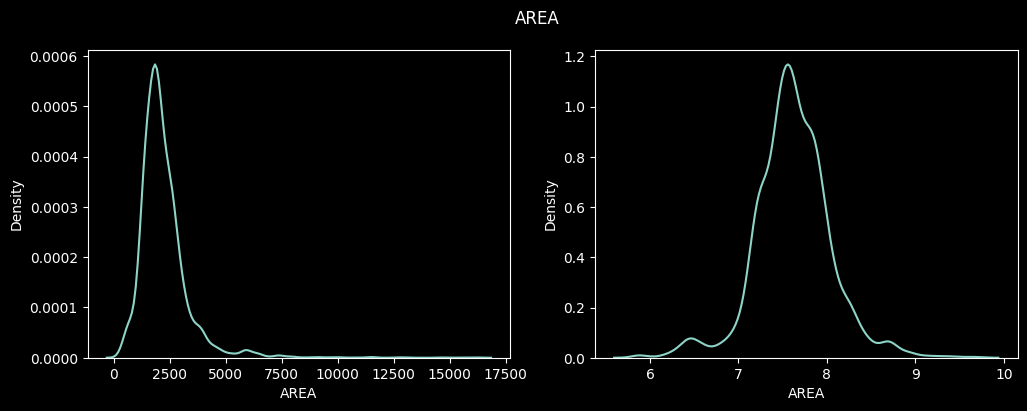

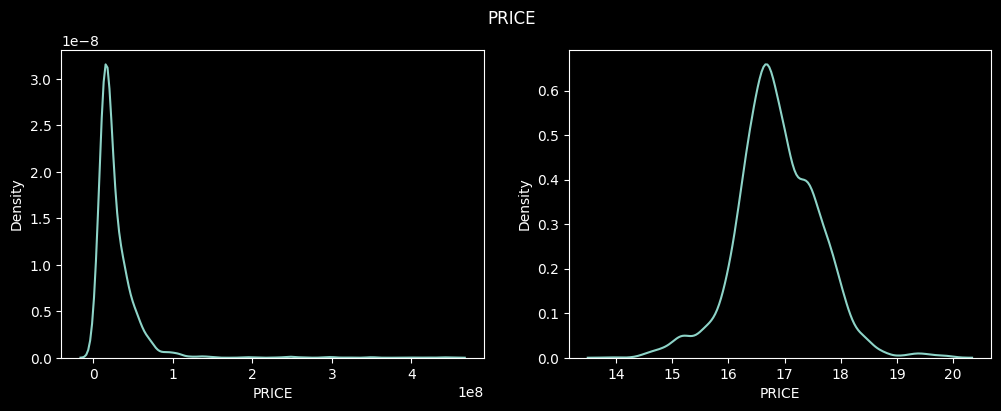

In [7]:
for i in ["AREA", "PRICE"]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.kdeplot(x=main_df[i], ax=ax1)
    sns.kdeplot(x=np.log1p(main_df[i]), ax=ax2)

    fig.suptitle(i)
    plt.show()

<Axes: >

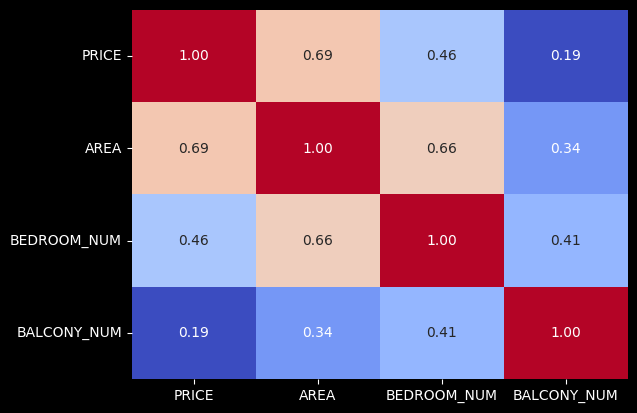

In [8]:
sns.heatmap(main_df.corr(numeric_only=True), cmap="coolwarm", cbar=False, annot=True, fmt=".2f")

### Encoding of categorical features

In [9]:
main_df["BEDROOM_NUM"] = main_df["BEDROOM_NUM"].apply(lambda x: x if x <= 5 else 99)
main_df["BALCONY_NUM"] = main_df["BALCONY_NUM"].apply(lambda x: x if x <= 4 else 99)

In [10]:
for col in cat_cols:
    if main_df[col].nunique() < 20:
        print(f"{col!r:>18}: {main_df[col].unique().tolist()}")
    else:
        print(f"{col!r:>18}: {main_df[col].nunique()}")

         'FURNISH': ['Furnished', 'Semifurnished', 'Unfurnished']
             'AGE': ['5-10 Year Old Property', '1-5 Year Old Property', 'Under Construction', '0-1 Year Old Property', '10+ Year Old Property']
     'BEDROOM_NUM': [5.0, 1.0, 2.0, 3.0, 4.0, 99.0]
     'BALCONY_NUM': [4.0, 1.0, 2.0, 3.0, 0.0]
       'FLOOR_NUM': ['low rise', 'mid rise', 'high rise']
          'FACING': ['North-East', 'East', 'North', 'South-East', 'South', 'West', 'South-West', 'North-West']
   'LOCALITY_NAME': 116


In [11]:
ord_cols = {
    "FURNISH": ["Unfurnished", "Semifurnished", "Furnished"],
    "AGE": [
        "10+ Year Old Property",
        "5-10 Year Old Property",
        "1-5 Year Old Property",
        "0-1 Year Old Property",
        "Under Construction",
    ],
    "BEDROOM_NUM": [1, 2, 3, 4, 5, 99],
    "BALCONY_NUM": [0, 1, 2, 3, 4, 99],
    "FLOOR_NUM": ["low rise", "mid rise", "high rise"],
}
ohe_cols = ["FACING", "LOCALITY_NAME"]

### Encoding Pipeline

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(categories=list(ord_cols.values())), list(ord_cols.keys())),
        ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ohe_cols),
        ("log1p_area", FunctionTransformer(np.log1p, np.expm1, validate=True), ["AREA"]),
    ],
    remainder="passthrough",
)

## Split Dataset

In [13]:
X = main_df.drop(columns=[target])
y = pd.Series(np.log1p(main_df[target]), name="PRICE")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train.shape, X_test.shape

((3239, 8), (810, 8))

In [15]:
def calc_scores(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)

    mae = mean_absolute_error(y_true, y_pred) / C.LAKH
    return mae

In [16]:
def create_model_pipe(estimator, preprocessor: ColumnTransformer | None):
    return Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("scaler", StandardScaler()),
            ("model", estimator),
        ]
    )

In [17]:
models_dict = {
    # This throw error that while transforming the y_pred data some data goes to infinity.
    # Also, it has very low r2_score approx (-7.778398599756416e+22)
    # "lr": LinearRegression(),
    "ridge_default": Ridge(),
    "rf_100": RandomForestRegressor(n_estimators=100),
    "rf_500": RandomForestRegressor(n_estimators=500),
    "svr_rbf": SVR(kernel="rbf"),
}

In [18]:
def calc_cv_score(X_train, y_train, *, X_test=None, y_test=None) -> dict:
    scores_dict = {}

    if X_test is None or y_test is None:
        X_test = X_train
        y_test = y_train

    for name, estimator in models_dict.items():
        start_time = perf_counter()
        scores = cross_val_score(
            model := create_model_pipe(estimator, preprocessor),
            X_train,
            y_train,
            cv=5,
            scoring="r2",
        )

        print(f"Fitting `{name}` model with {scores.mean():.3} R2 score.")
        model.fit(X_train, y_train)

        scores_dict[name] = {
            "r2_mean": scores.mean(),
            "r2_std": scores.std(),
            "mae": calc_scores(y_test, model.predict(X_test)),
        }
        print(f"{name} model takes {(perf_counter() - start_time):.3} seconds.\n")

    return scores_dict

In [19]:
def dict_to_df(d: dict) -> pd.DataFrame:
    return pd.DataFrame.from_dict(d, "index").sort_values("mae").round(3)

In [20]:
# Training model with testing datasets
scores_dict = calc_cv_score(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
dict_to_df(scores_dict)

Fitting `ridge_default` model with 0.856 R2 score.
ridge_default model takes 2.3694477919998462 seconds.

Fitting `rf_100` model with 0.879 R2 score.
rf_100 model takes 6.141623625000648 seconds.

Fitting `rf_1000` model with 0.881 R2 score.
rf_1000 model takes 57.83846100000028 seconds.

Fitting `svr_rbf` model with 0.856 R2 score.
svr_rbf model takes 2.2807846659998177 seconds.



,r2_mean,r2_std,mae
rf_1000,0.881,0.034,42.824
rf_100,0.879,0.034,42.873
svr_rbf,0.856,0.040,48.868
ridge_default,0.856,0.042,53.562


**Things to Note**

- I used `OneHotEncoder(sparse_output=False, handle_unknown="ignore")`. In this I compromized my unknown values in `LOCALITY_NAME` which comes in the testing data.
- I used `FunctionTransformer(np.log1p, np.expm1, validate=True)` to transform the `AREA` column which improve the model score because `AREA` column is **right skewed**.

### Train new model by transforming the whole `X` data at once and then split it into testing and training data.

In [21]:
scores_dict = calc_cv_score(X, y)
dict_to_df(scores_dict)

Fitting `ridge_default` model with -3.94 R2 score.
ridge_default model takes 2.4541650829996797 seconds.

Fitting `rf_100` model with -6.23 R2 score.
rf_100 model takes 7.710381082999447 seconds.

Fitting `rf_1000` model with -6.16 R2 score.
rf_1000 model takes 75.6956400830004 seconds.

Fitting `svr_rbf` model with -3.71 R2 score.
svr_rbf model takes 3.988472957999875 seconds.



,r2_mean,r2_std,mae
rf_1000,-6.161,2.497,15.241
rf_100,-6.234,2.480,15.678
svr_rbf,-3.706,1.533,39.115
ridge_default,-3.938,2.606,49.037
